# Predicting IDC in Breast Cancer Histology Images 
                                                                                 Zhanyi Tan

Context
Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. To assign an aggressiveness grade to a whole mount sample, pathologists typically focus on the regions which contain the IDC. As a result, one of the common pre-processing steps for automatic aggressiveness grading is to delineate the exact regions of IDC inside of a whole mount slide.

Content
The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). Each patch’s file name is of the format: u_xX_yY_classC.png — > example 10253_idx5_x1351_y1101_class0.png . Where u is the patient ID (10253_idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.

Acknowledgements
The original files are located here: http://gleason.case.edu/webdata/jpi-dl-tutorial/IDC_regular_ps50_idx5.zip Citation: https://www.ncbi.nlm.nih.gov/pubmed/27563488 and http://spie.org/Publications/Proceedings/Paper/10.1117/12.2043872

Inspiration
Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is the most common form of breast cancer. Accurately identifying and categorizing breast cancer subtypes is an important clinical task, and automated methods can be used to save time and reduce error.

                                                                        -----From kaggle

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import History
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import numpy
%matplotlib inline

Using TensorFlow backend.


# Part One: Load the local data

I download the dataset of Breast Histopathology Images from kaggle
https://www.kaggle.com/paultimothymooney/predict-idc-in-breast-cancer-histology-images/data

In [2]:
imagePatches = glob('C:/Users/jared/bhi/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

C:/Users/jared/bhi\8863\0\8863_idx5_x1001_y1001_class0.png
C:/Users/jared/bhi\8863\0\8863_idx5_x1001_y1051_class0.png
C:/Users/jared/bhi\8863\0\8863_idx5_x1001_y1101_class0.png
C:/Users/jared/bhi\8863\0\8863_idx5_x1001_y1151_class0.png
C:/Users/jared/bhi\8863\0\8863_idx5_x1001_y1201_class0.png
C:/Users/jared/bhi\8863\0\8863_idx5_x1001_y1251_class0.png
C:/Users/jared/bhi\8863\0\8863_idx5_x1001_y1301_class0.png
C:/Users/jared/bhi\8863\0\8863_idx5_x1001_y1351_class0.png
C:/Users/jared/bhi\8863\0\8863_idx5_x1001_y1401_class0.png
C:/Users/jared/bhi\8863\0\8863_idx5_x1001_y1451_class0.png


In [3]:
# we can see all these images are already classified, and its category is showed in its file name
# Each image are inserted into different list according to its file name
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['C:/Users/jared/bhi\\8863\\0\\8863_idx5_x1001_y1001_class0.png', 'C:/Users/jared/bhi\\8863\\0\\8863_idx5_x1001_y1051_class0.png', 'C:/Users/jared/bhi\\8863\\0\\8863_idx5_x1001_y1101_class0.png', 'C:/Users/jared/bhi\\8863\\0\\8863_idx5_x1001_y1151_class0.png', 'C:/Users/jared/bhi\\8863\\0\\8863_idx5_x1001_y1201_class0.png'] 

IDC(+)

 ['C:/Users/jared/bhi\\8863\\1\\8863_idx5_x1001_y1501_class1.png', 'C:/Users/jared/bhi\\8863\\1\\8863_idx5_x1001_y1551_class1.png', 'C:/Users/jared/bhi\\8863\\1\\8863_idx5_x1001_y1601_class1.png', 'C:/Users/jared/bhi\\8863\\1\\8863_idx5_x1001_y801_class1.png', 'C:/Users/jared/bhi\\8863\\1\\8863_idx5_x1001_y851_class1.png']


In [4]:
def read_img(img):
    img = cv2.imread(img)
    img = cv2.resize(img, (50,50))
    
    return img

# Part Two: Dataset Analysis and Data Augmentation

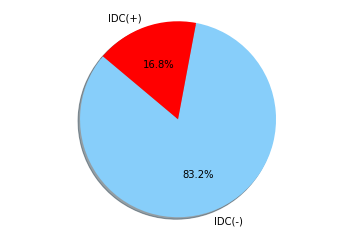

In [5]:
# show the portion of negative and positive data
labels = 'IDC(-)', 'IDC(+)'
sizes = [len(classZero), len(classOne)]
colors = ['lightskyblue','red']
 
# Plot
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

From the pie graph above, we can see this dataset is highly unbalanced.<br>
It is a big problem to train a model in a highly unbalanced dataset.<br>
To solve this problem. I use three data augmentation to increase the amout of positive sample.<br>

In [6]:
def augmentation1(img):                   # flip horizontally
    img = cv2.imread(img)
    img = cv2.resize(img, (50,50))
    augmented_img = np.fliplr(img)
    
    return augmented_img

def augmentation2(img):                   # flip vertically
    img = cv2.imread(img)
    img = cv2.resize(img, (50,50))
    augmented_img = np.flipud(img)
    
    return augmented_img

def noisy(image_name):                    # noisy image
    image = cv2.imread(image_name)        # need a rescale to be more realistic
    noisy = np.random.poisson(image / 255.0 * 300) / 300 * 255  
    noisy = cv2.resize(noisy, (50,50))
    noisy = noisy.astype(numpy.uint8)
    return noisy

## An oringinal image from dataset

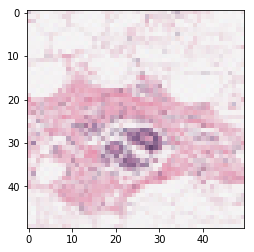

In [7]:
image_name = "C:/Users/jared/breast-histopathology-images/9135/0/9135_idx5_x1001_y1001_class0.png" #Image to be used as query
image = cv2.imread(image_name)
image = cv2.resize(image, (50,50))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Image output from augmentation functions 

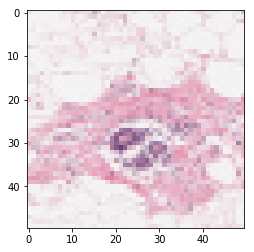

In [8]:
image = augmentation1(image_name)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

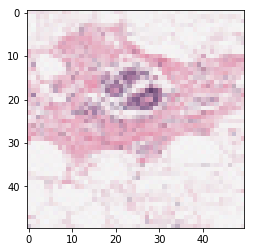

In [9]:
image = augmentation2(image_name)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

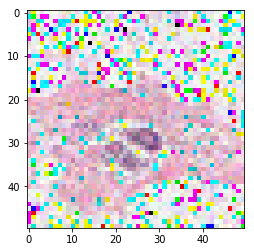

In [10]:
image = noisy(image_name)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [11]:

"""
    x is an array of resized images
    y is an array of labels
""" 
X = []
Y = []
WIDTH = 50
HEIGHT = 50
for img in imagePatches[0:9000]:
    X.append(read_img(img))
    if img in classZero:
        Y.append(0)
    elif img in classOne:             # if this image is idc positive, we need to apply data augentations to it
        a1img = augmentation1(img)
        a2img = augmentation1(img)
        nimg = noisy(img)
        X.append(a1img)
        X.append(a2img)
        X.append(nimg)
        Y.append(1)
        Y.append(1)
        Y.append(1)
        Y.append(1)
    else:
        break

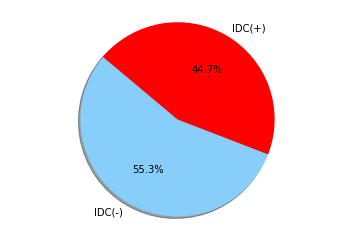

In [12]:
labels = 'IDC(-)', 'IDC(+)'
sizes = [len(classZero), len(classOne)*4]
colors = ['lightskyblue','red']
 
# Plot
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

Now, the dataset's distribution looks much better. The amounts of Positive and neative samples are very close  <br>

In [13]:
X=np.array(X)
# split the dataset in 80:20 for training and validating
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (5377, 50, 50, 3)
Testing Data Shape: (1345, 50, 50, 3)


In [14]:
imgs1 = []
imgs0 = []
for x in range(500):
    if Y_train[x] == 1:
        imgs1.append(X_train[x])
    if Y_train[x] == 0:
        imgs0.append(X_train[x])

In below I show some images which have labels IDC(-) (diagnosis neagtive) and IDC(+) (diagnosis positive) to give us a hint what is the difference between them.

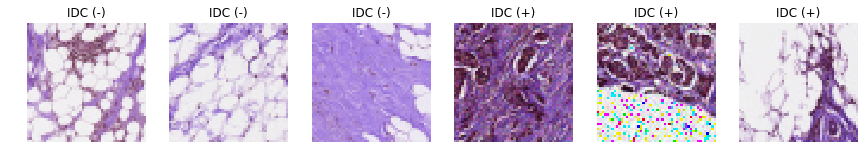

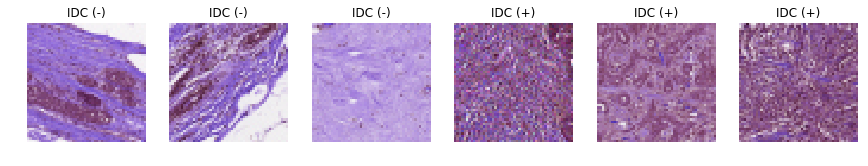

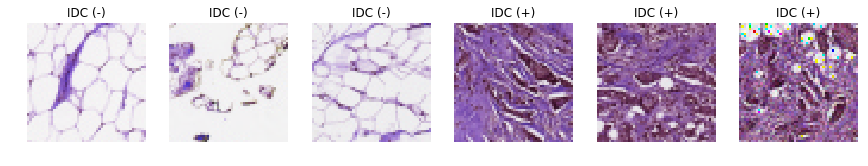

In [15]:
for row in range(3):
    plt.figure(figsize=(20, 10))
    for col in range(3):
        plt.subplot(1,8,col+1)
        plt.title('IDC (-)')
        plt.imshow(imgs0[0+4*row+col])
        plt.axis('off')       
        plt.subplot(1,8,col+4)
        plt.title('IDC (+)')
        plt.imshow(imgs1[0+4*row+col])
        plt.axis('off')

From the images above, we can see the differences between IDC+ and IDC- <br>
This difference is distinguishable. I believe it will not be hard for my model to classify them<br> 

# Part Three: Build the Model

In [16]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(50,50,3),
                 strides=2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               991360    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [17]:
# In here, I use data generator which can randomly modify my data. This process can help me avoid overfit.
datagen = ImageDataGenerator(
    rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True)  # randomly flip images

In [18]:
model.compile(loss='binary_crossentropy', optimizer= 'adam' , metrics=['accuracy'])

In [19]:
from keras.callbacks import History
history = History()
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=32), steps_per_epoch=len(X_train) /32,validation_data = [X_test, Y_test],epochs=20,callbacks=[history],verbose=1)

Epoch 1/20
169/168 [==============================] - 15s 88ms/step - loss: 8.8574 - acc: 0.4438 - val_loss: 8.6527 - val_acc: 0.4572
Epoch 2/20
169/168 [==============================] - 15s 87ms/step - loss: 8.8878 - acc: 0.4425 - val_loss: 8.6527 - val_acc: 0.4572
Epoch 3/20
169/168 [==============================] - 15s 88ms/step - loss: 8.8878 - acc: 0.4425 - val_loss: 8.6527 - val_acc: 0.4572
Epoch 4/20
169/168 [==============================] - 14s 85ms/step - loss: 8.7969 - acc: 0.4482 - val_loss: 8.6527 - val_acc: 0.4572
Epoch 5/20
169/168 [==============================] - 14s 82ms/step - loss: 8.7969 - acc: 0.4482 - val_loss: 8.6527 - val_acc: 0.4572
Epoch 6/20
169/168 [==============================] - 14s 83ms/step - loss: 8.7969 - acc: 0.4482 - val_loss: 8.6527 - val_acc: 0.4572
Epoch 7/20
169/168 [==============================] - 14s 83ms/step - loss: 8.8878 - acc: 0.4425 - val_loss: 8.6527 - val_acc: 0.4572
Epoch 8/20
169/168 [==============================] - 14s 83ms

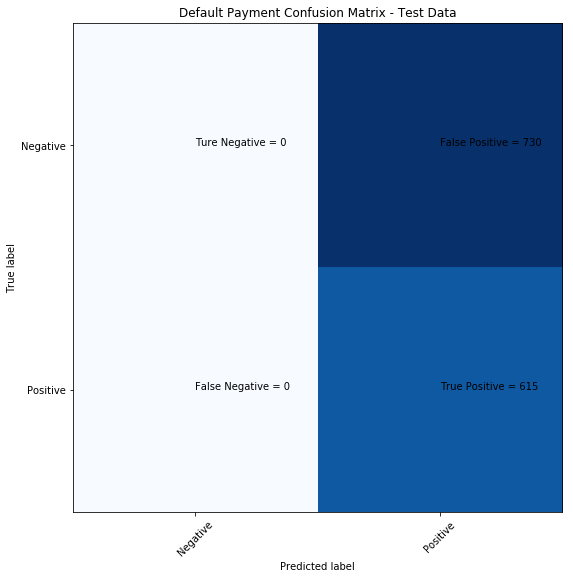

In [20]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
cm = confusion_matrix(Y_test, y_pred)
plt.clf()
plt.figure(figsize = (16,9))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
ticks = ['Negative','Positive']
plt.title('Default Payment Confusion Matrix - Test Data')
tick_marks = np.arange(len(ticks))
plt.xticks(tick_marks, ticks, rotation=45)
plt.yticks(tick_marks, ticks)
s = [['Ture Negative','False Positive'], ['False Negative', 'True Positive']]

for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

The proformance of this model is terrible. It has accuaracy around 55%, which is close to the portion of IDC- in the dataset.<br>
From the confusion matrix above, we can see that it simply classify every sample as IDC(-)<br>
I would say this model is lazy, and it fails to achieve my goal.<br>

# Part Four: Transfer Learning

In this part I try to apply transfer learning by the vgg16 model. I take all the convolutional layers only, and add a fully connected layer at the top of the model. One important thing is to set all the convolutional layers to not trainable. By doing this we can save a lot of time at the training process without losing accuracy.

In [23]:
from keras.layers import Input
from keras.models import Model
from keras.applications.vgg16 import VGG16

model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

#Create your own input format (here 3x200x200)
input = Input(shape=(50,50,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

for layer in model_vgg16_conv.layers:
    layer.trainable = False
    
#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

#Create your own model 
my_model = Model(input=input, output=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

G:\anaconda\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


In [24]:
my_model.compile(loss='binary_crossentropy', optimizer= 'adam' , metrics=['accuracy'])

In [25]:
from keras.callbacks import History
history = History()
history = my_model.fit_generator(datagen.flow(X_train,Y_train, batch_size=32), steps_per_epoch=len(X_train) /32,validation_data = [X_test, Y_test],epochs=20,callbacks=[history],verbose=1)

Epoch 1/20
169/168 [==============================] - 153s 903ms/step - loss: 2.2182 - acc: 0.7984 - val_loss: 1.5622 - val_acc: 0.8439
Epoch 2/20
169/168 [==============================] - 152s 900ms/step - loss: 1.6466 - acc: 0.8400 - val_loss: 0.9159 - val_acc: 0.8639
Epoch 3/20
169/168 [==============================] - 143s 848ms/step - loss: 1.1372 - acc: 0.8419 - val_loss: 0.5542 - val_acc: 0.8149
Epoch 4/20
169/168 [==============================] - 142s 841ms/step - loss: 0.6160 - acc: 0.8256 - val_loss: 0.3672 - val_acc: 0.8416
Epoch 5/20
169/168 [==============================] - 142s 843ms/step - loss: 0.4513 - acc: 0.8402 - val_loss: 0.3426 - val_acc: 0.8483
Epoch 6/20
169/168 [==============================] - 142s 839ms/step - loss: 0.3877 - acc: 0.8550 - val_loss: 0.3193 - val_acc: 0.8729
Epoch 7/20
169/168 [==============================] - 141s 837ms/step - loss: 0.3614 - acc: 0.8585 - val_loss: 0.3209 - val_acc: 0.8587
Epoch 8/20
169/168 [============================

# Part Five: Performance Analysis

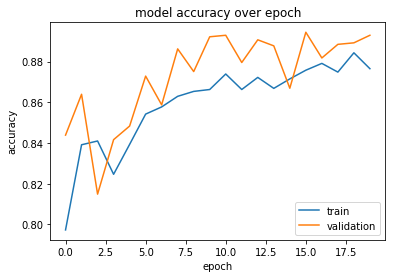

In [26]:
#show the trend of model accuracy over 200 epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('model accuracy over epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

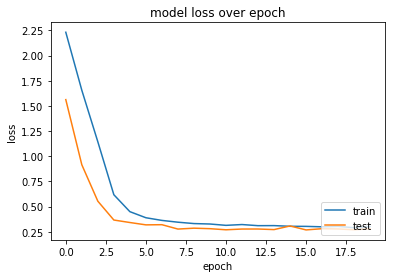

In [27]:
#show the trend of loss over 10 epoches
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model loss over epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

From the trend lane graphs above, we can see the validation accuracy is higher than the training accuracy.<br>
Training loss converges to the testing loss<br>
It is sufficient to show that our model is neither underfit nor overfit.<br>

In [28]:
scores = my_model.evaluate(X_test, Y_test, verbose=False)
print("Accuracy rate: %.2f%%" % (scores[1]*100))
print('Test loss:', scores[0])

Accuracy rate: 89.29%
Test loss: 0.280614153359


Our model have an 89% accuracy rate, which indicates it has a good performance. 

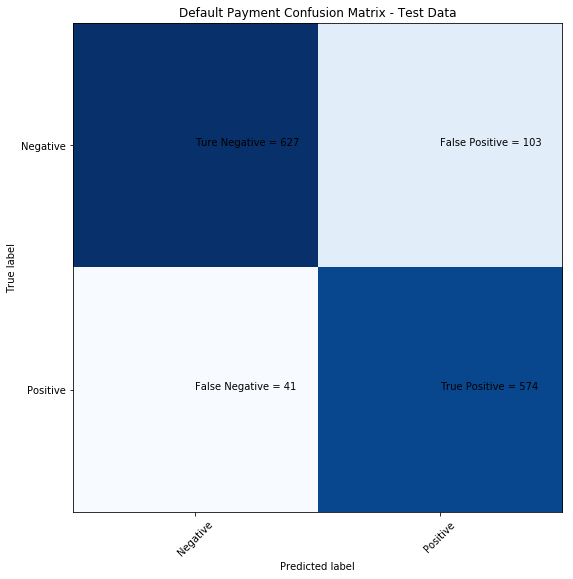

In [29]:
y_pred = my_model.predict(X_test)
y_pred = (y_pred > 0.5)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
cm = confusion_matrix(Y_test, y_pred)
plt.clf()
plt.figure(figsize = (16,9))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
ticks = ['Negative','Positive']
plt.title('Default Payment Confusion Matrix - Test Data')
tick_marks = np.arange(len(ticks))
plt.xticks(tick_marks, ticks, rotation=45)
plt.yticks(tick_marks, ticks)
s = [['Ture Negative','False Positive'], ['False Negative', 'True Positive']]

for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

The confusion matrix above indicates that our model can make correct prediction for most of the time. There is only less than 10% wrong prediction.